# Read all the hap.py vcfs and compute overlaps

Needs an environment with pyvcf and other anaconda packages.

Because it needs pyvcf, the dependencies dictate that it will have an older version of seaborn and others.

In [1]:
import vcf
import vcf.utils
import glob
import re
import pandas as pd
import upsetplot
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

## Read metadata

In [2]:
paths = glob.glob("d50_variant_analysis/*/*vcf.gz")

In [3]:
names, kits, concs, replicates = zip(*[
    re.match(r".*/(([A-Za-z0-9]+)-(\d+ng)-(\d))\.vcf\.gz", path).groups()
    for path in paths
])

## Data frame for metadata summary

In [4]:
df = pd.DataFrame({'Name': names, 'Kit': kits, 'Conc': concs, 'Replicate': replicates, 'Path': paths})

In [5]:
df.head()

,Name,Kit,Conc,Replicate,Path
0,Kapa-10ng-2,Kapa,10ng,2,d50_variant_analysis/Kapa-10ng-2_happy/Kapa-10...
1,Kapa-100ng-2,Kapa,100ng,2,d50_variant_analysis/Kapa-100ng-2_happy/Kapa-1...
2,NEB-10ng-2,NEB,10ng,2,d50_variant_analysis/NEB-10ng-2_happy/NEB-10ng...
3,Swift2S-10ng-2,Swift2S,10ng,2,d50_variant_analysis/Swift2S-10ng-2_happy/Swif...
4,Swiftlong-10ng-1,Swiftlong,10ng,1,d50_variant_analysis/Swiftlong-10ng-1_happy/Sw...


### Only analyse 100 ng data

In [6]:
# af = analysis data frame
af = df[(df.Conc=='100ng')&(df.Kit!="Swiftlong")].copy()

In [7]:
kits = list(set(af.Kit))
print(kits)

['Nextera', 'Kapa', 'Swift2S', 'NEB', 'Quanta']


# Set it here, people:

In [29]:
MINIMUM_NUM_REPLICATES = 2

### Find quality cut-offs for picking N true positives

In [9]:
# Nextera @ QQ>-5: 11269522
N = 2_800_000
N2 = 2_700_000
nbatch = 10000
q_cuts = []
q_n2 = []
i=0
for kit in kits:
    #break # Skip this loop -- computed values for normalisation mode "d" given below
    readers = [vcf.Reader(filename=path) for path in af[af.Kit==kit].Path]
    print("Analysing", len(readers), "files for kit", kit, ".")
    qvals = np.array([])
    ibatch = 0
    n_rows = 0
    batch = np.zeros(nbatch)
    for variants in vcf.utils.walk_together(*readers):
        n_rows += 1
        if any(var.samples[0].data.BVT == 'SNP' for var in variants if var):
            replicates_qvals = sorted([var.samples[1].data.QQ for var in variants
                     if var and var.samples[1].data.BD=='TP'])
            if len(replicates_qvals) > 2:
                batch[ibatch] = replicates_qvals[-3]
                ibatch += 1
                if ibatch == nbatch:
                    ii = np.searchsorted(qvals, batch)
                    qvals = np.insert(qvals, ii, batch)[-(N+1):]
                    ibatch = 0
    ii = np.searchsorted(qvals, batch[0:ibatch])
    qvals = np.insert(qvals, ii, batch[0:ibatch])[-(N+1):]
    print('Kit', kit, ' - Processed', n_rows, 'rows.')
    print('Kit', kit, 'QQ >', qvals[0], "(", len(qvals)-1, " variants)")
    q_cuts.append(qvals[0])
    if len(qvals) > N2+1:
        print('Kit', kit, 'QQ >', qvals[-(N2+1)], "(", N2, "variants)")
        q_n2.append(qvals[-(N2+1)])

Analysing 4 files for kit Kapa .
Kit Kapa  - Processed 5288817 rows.
Kit Kapa QQ > -16.118 ( 2717780  variants)
Kit Kapa QQ > -2.935 ( 2700000 variants)
Analysing 4 files for kit NEB .
Kit NEB  - Processed 5504887 rows.
Kit NEB QQ > -16.118 ( 2743262  variants)
Kit NEB QQ > -2.25 ( 2700000 variants)
Analysing 4 files for kit Swift2S .
Kit Swift2S  - Processed 5515923 rows.
Kit Swift2S QQ > -16.118 ( 2730591  variants)
Kit Swift2S QQ > -2.466 ( 2700000 variants)
Analysing 4 files for kit Quanta .
Kit Quanta  - Processed 5396280 rows.
Kit Quanta QQ > -16.118 ( 2724454  variants)
Kit Quanta QQ > -2.617 ( 2700000 variants)
Analysing 4 files for kit Nextera .
Kit Nextera  - Processed 5093068 rows.
Kit Nextera QQ > -16.118 ( 2701510  variants)
Kit Nextera QQ > -5.141 ( 2700000 variants)


In [8]:
print("q_cuts =", repr(q_cuts))
print("q_n2 =", repr(q_n2))

NameError: name 'q_cuts' is not defined

## Notes

### >2 replicates; 2.8M & 2.7M cut-offs ( 2.8 didn't have enough )

    q_cuts = [-0.966, -0.859, -0.962, -1.029, -0.905]
    q_n2 = [-0.142, -0.125, -0.218, 0.001, -0.148]



In [9]:
## OVERRIDING IT HERE!
q_n2 = [-0.142, -0.125, -0.218, 0.001, -0.148]


#qq_cuts_dict = {}
#qq_cuts_dict['Kapa'] = -1.6
#qq_cuts_dict['NEB'] = -1.595
#qq_cuts_dict['Swift2S'] = -1.603
#qq_cuts_dict['Nextera'] = -2.308
#qq_cuts_dict['Quanta'] = -1.998
qq_cuts_dict = dict(zip(kits, q_n2))

## Make a place to hold the counts

`group_combinations`

| Truth | Type  | Value |
|-------|-------|-------|
| True  | SNP   | Series counts |
| False | SNP   | Series counts |
| True  | INDEL | Series counts |
| False | INDEL | Series counts |

Series counts are series containing the counts of each combination of callers. The indexes are MultiIndexes with one level for each kit, with value True if the variant is called, False otherwise.

In [10]:
group_counts_idx = pd.MultiIndex.from_product([[True,False] for _ in kits], names=kits)
types = ['SNP', 'INDEL'] # May need to refactor if we're to separate indel types

In [11]:
kits

['Nextera', 'Kapa', 'Swift2S', 'NEB', 'Quanta']

## VCF Reading loop

In [30]:
kits_readers = [(row.Kit, vcf.Reader(filename=row.Path)) for _, row in af.iterrows()]
kits_in_order, readers = zip(*kits_readers)

print(list(kits_in_order))

abort = 12000000
#abort = 200000000

group_combinations = {
    (truth, typ): pd.Series(index=group_counts_idx, dtype='uint32')
    for typ in types
    for truth in [True, False]
    }
intra_kit_consensus = {kitname: [0, 0, 0, 0, 0] for kitname in kits}

tp_counters = [0] * len(readers)
n_kap_ctr = 0
for variants in vcf.utils.walk_together(*readers):
    if abort == 0:
        break
    else:
        abort -= 1
        if abort % 100000 == 0:
            print("kapa variants TP found", n_kap_ctr)
            print(abort, "variants remaining...")
            
    is_true = (variants[0] and variants[0].samples[0].data.BD in ['TP', 'FN']) == True
    
    if not is_true:
        for var in variants:
            if var and var.samples[0].data.BD == 'TP':
                print("WTFingF?", var.CHROM, var.POS)
                raise WTF
    
    typ = next(iter(
        vcall.samples[isam].data.BVT
        for vcall in variants
        for isam in [0,1]
        if vcall and vcall.samples[isam].data.BVT != 'NOCALL'
    ))
    
    var_group_counts = [0] * len(kits)
    for vcall, kit in zip(variants, kits_in_order):
        if vcall:
            #if vcall.samples[1].data.BD == 'TP' and vcall.samples[1].data.QQ > qq_cuts_dict[kit]:
            if vcall.samples[1].data.BD == 'TP' and vcall.samples[1].data.QQ > -5:
                var_group_counts[kits.index(kit)] += 1
    
    if is_true:
        for i, kit in enumerate(kits):
            intra_kit_consensus[kit][var_group_counts[i]] += 1
    
    combinations_index = tuple(x >= MINIMUM_NUM_REPLICATES for x in var_group_counts)
    if is_true and combinations_index[0]: n_kap_ctr+=1
    
    group_combinations[(is_true, typ)][combinations_index] += 1


['Kapa', 'Kapa', 'Quanta', 'Nextera', 'NEB', 'Swift2S', 'Kapa', 'Quanta', 'NEB', 'Nextera', 'Swift2S', 'NEB', 'Nextera', 'Swift2S', 'Quanta', 'Kapa', 'NEB', 'Quanta', 'Nextera', 'Swift2S']
kapa variants TP found 46542
11900000 variants remaining...
kapa variants TP found 101282
11800000 variants remaining...
kapa variants TP found 149975
11700000 variants remaining...
kapa variants TP found 173978
11600000 variants remaining...
kapa variants TP found 230537
11500000 variants remaining...
kapa variants TP found 286565
11400000 variants remaining...
kapa variants TP found 343147
11300000 variants remaining...
kapa variants TP found 387069
11200000 variants remaining...
kapa variants TP found 440160
11100000 variants remaining...
kapa variants TP found 497655
11000000 variants remaining...
kapa variants TP found 554851
10900000 variants remaining...
kapa variants TP found 605502
10800000 variants remaining...
kapa variants TP found 663672
10700000 variants remaining...
kapa variants TP fo

KeyboardInterrupt: 

### Total counts

## NOTAT: Kjører = 2 replikatter

In [13]:
for typ in ['SNP', 'INDEL']:
    truecalls = group_combinations[(True, typ)]
    for kit in kits:
        print(f"kit {kit:9}  - Total true {typ} :", truecalls[truecalls.index.get_level_values(kit)].sum())

kit Nextera    - Total true SNP : 3552195
kit Kapa       - Total true SNP : 3545070
kit Swift2S    - Total true SNP : 3547075
kit NEB        - Total true SNP : 3540117
kit Quanta     - Total true SNP : 3549708
kit Nextera    - Total true INDEL : 545510
kit Kapa       - Total true INDEL : 558526
kit Swift2S    - Total true INDEL : 554386
kit NEB        - Total true INDEL : 558418
kit Quanta     - Total true INDEL : 558259


### Experimental colouring by true/false

In [14]:
# Make TP/FP in single data frame
group_data = {}
for typ in ['SNP', 'INDEL']:
    group_data[typ] = pd.concat([
        pd.DataFrame({'Count': group_combinations[(truth, 'SNP')]}).assign(Truth=truth)
        for truth in [True, False]
    ])

In [15]:
#upsetplot.plot(group_combinations.drop(tuple([0]*len(kits))).drop(tuple([1]*len(kits))), sort_by='cardinality')
up = upsetplot.UpSet(
    group_data['SNP'].drop(tuple([False]*len(kits))),
    sort_by='cardinality',
    sort_categories_by=None,
    sum_over='Count'
)

In [16]:
totales_orig_save = upsetplot.UpSet.plot_totals

In [17]:
def plot_totals_mar(self, ax, hue):
    """Plot bars indicating total set size
    """
    orig_ax = ax
    ax = self._reorient(ax)
    recst = sns.barplot()
    rects = ax.barh(np.arange(len(self.totals.index.values)), self.totals,
                    .5, color=self._facecolor, align='center')
    self._label_sizes(ax, rects, 'left' if self._horizontal else 'top')

    max_total = self.totals.max()
    if self._horizontal:
        orig_ax.set_xlim(max_total, 0)
    for x in ['top', 'left', 'right']:
        ax.spines[self._reorient(x)].set_visible(False)
    ax.yaxis.set_visible(False)
    ax.xaxis.grid(True)
    ax.yaxis.grid(False)
    ax.patch.set_visible(False)


[{'type': 'default', 'id': 'intersections', 'elements': 6}, {'type': 'stacked_bars', 'by': 'Truth', 'sum_over': 'Count', 'colors': None, 'title': None, 'id': 'extra1', 'elements': 6}]


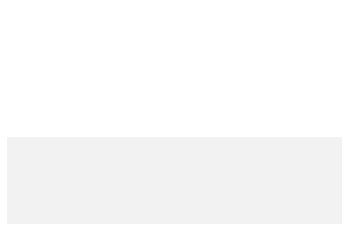

In [18]:
up.add_stacked_bars('Truth', sum_over='Count', elements=6)
print(up._subset_plots)
up._subset_plots.pop(0)
f = plt.figure()
up.plot_shading(plt.axes())

In [19]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(group_data['SNP'])

Count  Truth
Nextera Kapa  Swift2S NEB   Quanta                
True    True  True    True  True    3404639   True
                            False     27307   True
                      False True      31689   True
                            False      3249   True
              False   True  True      27975   True
                            False      2480   True
                      False True       3764   True
                            False      2028   True
        False True    True  True      29231   True
                            False      2539   True
                      False True       3982   True
                            False      2077   True
              False   True  True       2911   True
                            False      1473   True
                      False True       2704   True
                            False      4147   True
False   True  True    True  True      30483   True
                            False      2102   True
                      False True       2377   True
                            False      1024   True
              False   True  True       2094   True
                            False       941   True
                      False True       1184   True
                            False      1734   True
        False True    True  True       2192   True
                            False      1079   True
                      False True       1223   True
                            False      1882   True
              False   True  True       1103   True
                            False      1568   True
                      False True       2157   True
                            False     14902   True
True    True  True    True  True        606  False
                            False        66  False
                      False True         56  False
                            False        25  False
              False   True  True         52  False
                            False        20  False
                      False True         22  False
                            False         9  False
        False True    True  True         31  False
                            False        16  False
                      False True         13  False
                            False         8  False
              False   True  True         23  False
                            False        11  False
                      False True         14  False
                            False        28  False
False   True  True    True  True         95  False
                            False        38  False
                      False True         29  False
                            False        22  False
              False   True  True         31  False
                            False        17  False
                      False True         18  False
                            False        34  False
        False True    True  True         25  False
                            False        22  False
                      False True         34  False
                            False        43  False
              False   True  True         17  False
                            False        34  False
                      False True         41  False
                            False   1746833  False

In [20]:
group_combinations[(True,'SNP')].sum()

3620240

### Normal plot for true/false positives separately

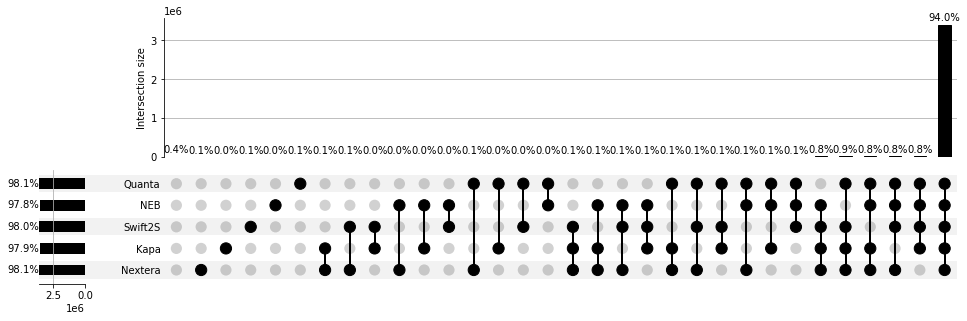

In [21]:
up = upsetplot.UpSet(group_combinations[(True,'SNP')], sort_by='degree', sort_categories_by=None, show_percentages=True)
frames = up.plot()
#frames['intersections'].set_ylim(0, group_combinations[(True, 'SNP')][(False, True, True, True, True)] * 1.1)

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

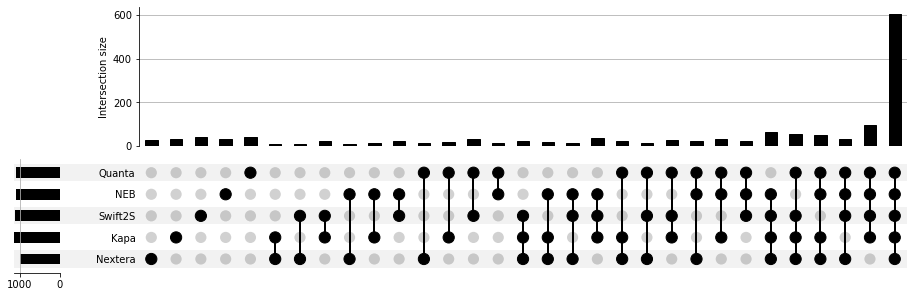

In [22]:
upsetplot.plot(group_combinations[(False,'SNP')].drop(tuple([0]*len(kits))), sort_by='degree', sort_categories_by=None)

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

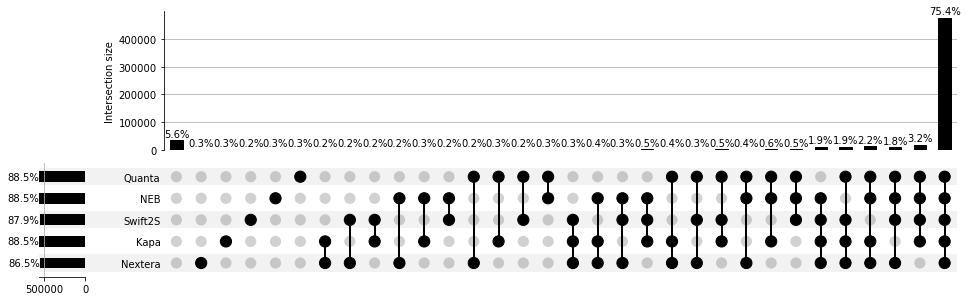

In [23]:
upsetplot.plot(group_combinations[(True, 'INDEL')], sort_by='degree', sort_categories_by=None, show_percentages=True)

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

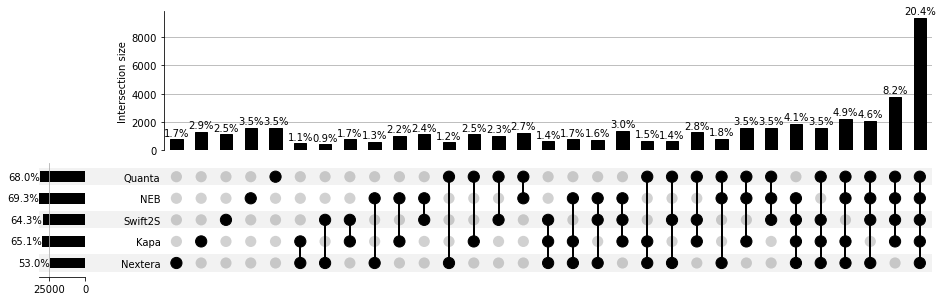

In [24]:
upsetplot.plot(group_combinations[(False, 'INDEL')].drop(tuple([0]*len(kits))), sort_by='degree', sort_categories_by=None, show_percentages=True)

## Test / experimenting

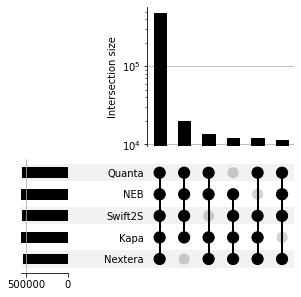

In [25]:
subplots = upsetplot.plot(group_combinations[(True, 'INDEL')].drop(tuple([0]*len(kits))), sort_by='cardinality', sort_categories_by=None, min_degree=4)
subplots['intersections'].set_yscale('log')

In [ ]:
intra_kit_consensus

In [26]:
kit_numreplicates_trueposcount = [
    (kit, num_replicates_called, intra_kit_consensus[kit][num_replicates_called])
    for num_replicates_called in [0,1,2,3,4]
    for kit in kits
]

In [27]:
iccdf = pd.DataFrame(data=kit_numreplicates_trueposcount, columns=['Kit', 'NumReplicatesHave', 'NumTpCalls'])

<AxesSubplot:xlabel='NumReplicatesHave', ylabel='NumTpCalls'>

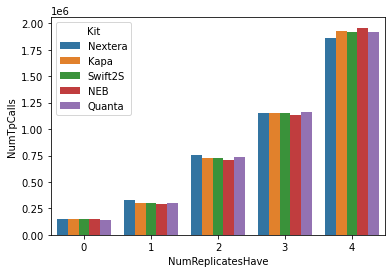

In [28]:
sns.barplot(data=iccdf, x='NumReplicatesHave', y='NumTpCalls', hue='Kit')

## Export data to csv

In [ ]:
dataframes = []
for (truth, typ) in [(True, 'SNP'), (True, 'INDEL'), (False, 'SNP'), (False, 'INDEL')]:
    part_df = group_combinations[(truth, typ)].reset_index().rename(columns={0: 'Count'})
    part_df['Truth'] = truth
    part_df['Type'] = typ
    dataframes.append(part_df)
full_df = pd.concat(dataframes)
# Uncomment this to write / overwrite the file
#full_df.to_csv('summary-tables/call-intersection-data.csv', index=False)
full_df.head(n=1)

# Load exported data

In [ ]:
full_df = pd.read_csv('summary-tables/call-intersection-data-d.csv')
group_combinations2 = {}
for (truth, typ) in [(True, 'SNP'), (True, 'INDEL'), (False, 'SNP'), (False, 'INDEL')]:
    part_df = full_df.loc[(full_df.Type==typ)&(full_df.Truth==truth)].set_index(kits)
    group_combinations2[(truth, typ)] = part_df.Count

print(group_combinations2[(True, 'SNP')].head(n=1))

In [ ]:
# Uncomment this to load from file 
#group_combinations = group_combinations2

# Testing / Experiment

In [ ]:
løk = pd.DataFrame(
    {
        #'Kit': ['Nextera', 'NEB', 'Nextera', 'NEB', 'Nextera', 'NEB'],
        'Nextera': [True, True, True, False, False, True],
        'NEB':   [ False, True, True, False, False, True],
        'Type':  ['SNP','SNP','SNP','INDEL','SNP','SNP']
    }
).set_index(['Nextera', 'NEB'])
up = upsetplot.UpSet(løk)
up.add_stacked_bars('Type')
up.plot()

In [ ]:
plt.subplots(2, 2)

In [ ]:
(fig, (tops, bots)) = plt.subplots(2, 2)
up2 = upsetplot.UpSet(løk)
up2.plot_matrix(bots[1])
up2.add_stacked_bars('Type')

# SNP count double check with bcftools

In [ ]:
af_names = list(os.path.basename(p).replace(".vcf.gz","") for p in af.Path)
print(" ".join(af_names))

In [ ]:
af['bcftoolsTpCount'] = [int(open(f"tmp-snpcounts/tp-{n}.txt").read().strip()) for n in af_names]
af['bcftoolsFpCount'] = [int(open(f"tmp-snpcounts/fp-{n}.txt").read().strip()) for n in af_names]
print(af.groupby("Kit").bcftoolsTpCount.sum())
print(af.groupby("Kit").bcftoolsFpCount.sum())
print(af.groupby("Kit").apply(lambda row: row.bcftoolsTpCount.sum() / (row.bcftoolsTpCount.sum() + row.bcftoolsFpCount.sum())))